In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap

In [18]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import imodels
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
# change working directory to imodels-experiment folder
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../../imodels-experiments')
    
module_path_imodels = os.getcwd()
if module_path not in sys.path:
    sys.path.append(module_path_imodels+"/config/shrinkage")
    
from imodels.util.data_util import get_clean_dataset
from datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from util import DATASET_PATH

pd.options.display.max_rows = 100

# Recreation of results from hierarchical shrinkage paper

Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models <br>
[Link to paper](https://proceedings.mlr.press/v162/agarwal22b.html)


>HS is integrated into the imodels package [imodels](github.com/csinva/imodels) (Singh et al., 2021) with an sklearn compatible API. Experiments for reproducing the results here can be found at [imodels-experiments](github.com/Yu-Group/imodels-experiments)

## Toy univariate regression problems (Figure 2)

Code for simulation taken from this [notebook](https://github.com/Yu-Group/imodels-experiments/blob/master/notebooks/shrinkage/03_shrinkage_example.ipynb)

In [5]:
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [6]:
def plot_sim(n=50, std=1, reg_param=0, show=True, linear_data=False, return_curves=False, use_imodels=True, ax=None):
    
    if ax == None:
        ax = plt.axes()
    
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std


    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    #return X, y, X_tile, y_tile
    
    # for original plots use sklearn and imodels
    if use_imodels:
        m1 = DecisionTreeRegressor(random_state=1)  #, max_leaf_nodes=15)
        m1.fit(X.reshape(-1, 1), y)
        y_pred_dt = m1.predict(X_tile.reshape(-1, 1))

        mshrunk = imodels.HSTreeRegressor(deepcopy(m1), reg_param=reg_param)
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))

    #use TreeModelsfromScratch package
    else:
        m1 = DecisionTree(treetype="regression", random_state=1)
        m1.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_dt = m1.predict(X_tile.reshape(-1,1))
        
        mshrunk = DecisionTree(treetype="regression", HShrinkage=True, HS_lambda=reg_param, random_state=1)
        mshrunk.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))
    
    ax.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)    
    ax.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3)    
    ax.plot(X_tile, y_pred_dt, '-', label='CART', color="skyblue", alpha=0.5, lw=4)
    ax.plot(X_tile, y_pred_shrunk, label='hsCART', color='#ff4b33', alpha=0.5, lw=4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    #dvu.line_legend(adjust_text_labels=False)
    if show == 'save':
        ax.savefig(f'gif/{reg_param}.svg')
    elif show == 'pass':
        pass
    elif show:
        ax.show()
    else:
        ax.close()

    if return_curves:
        return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk

#     print('dt', export_text(m1, feature_names=['X']))
#     print('dt', export_text(mshrunk.estimator_, feature_names=['X']))

# plot_sim(n=100)

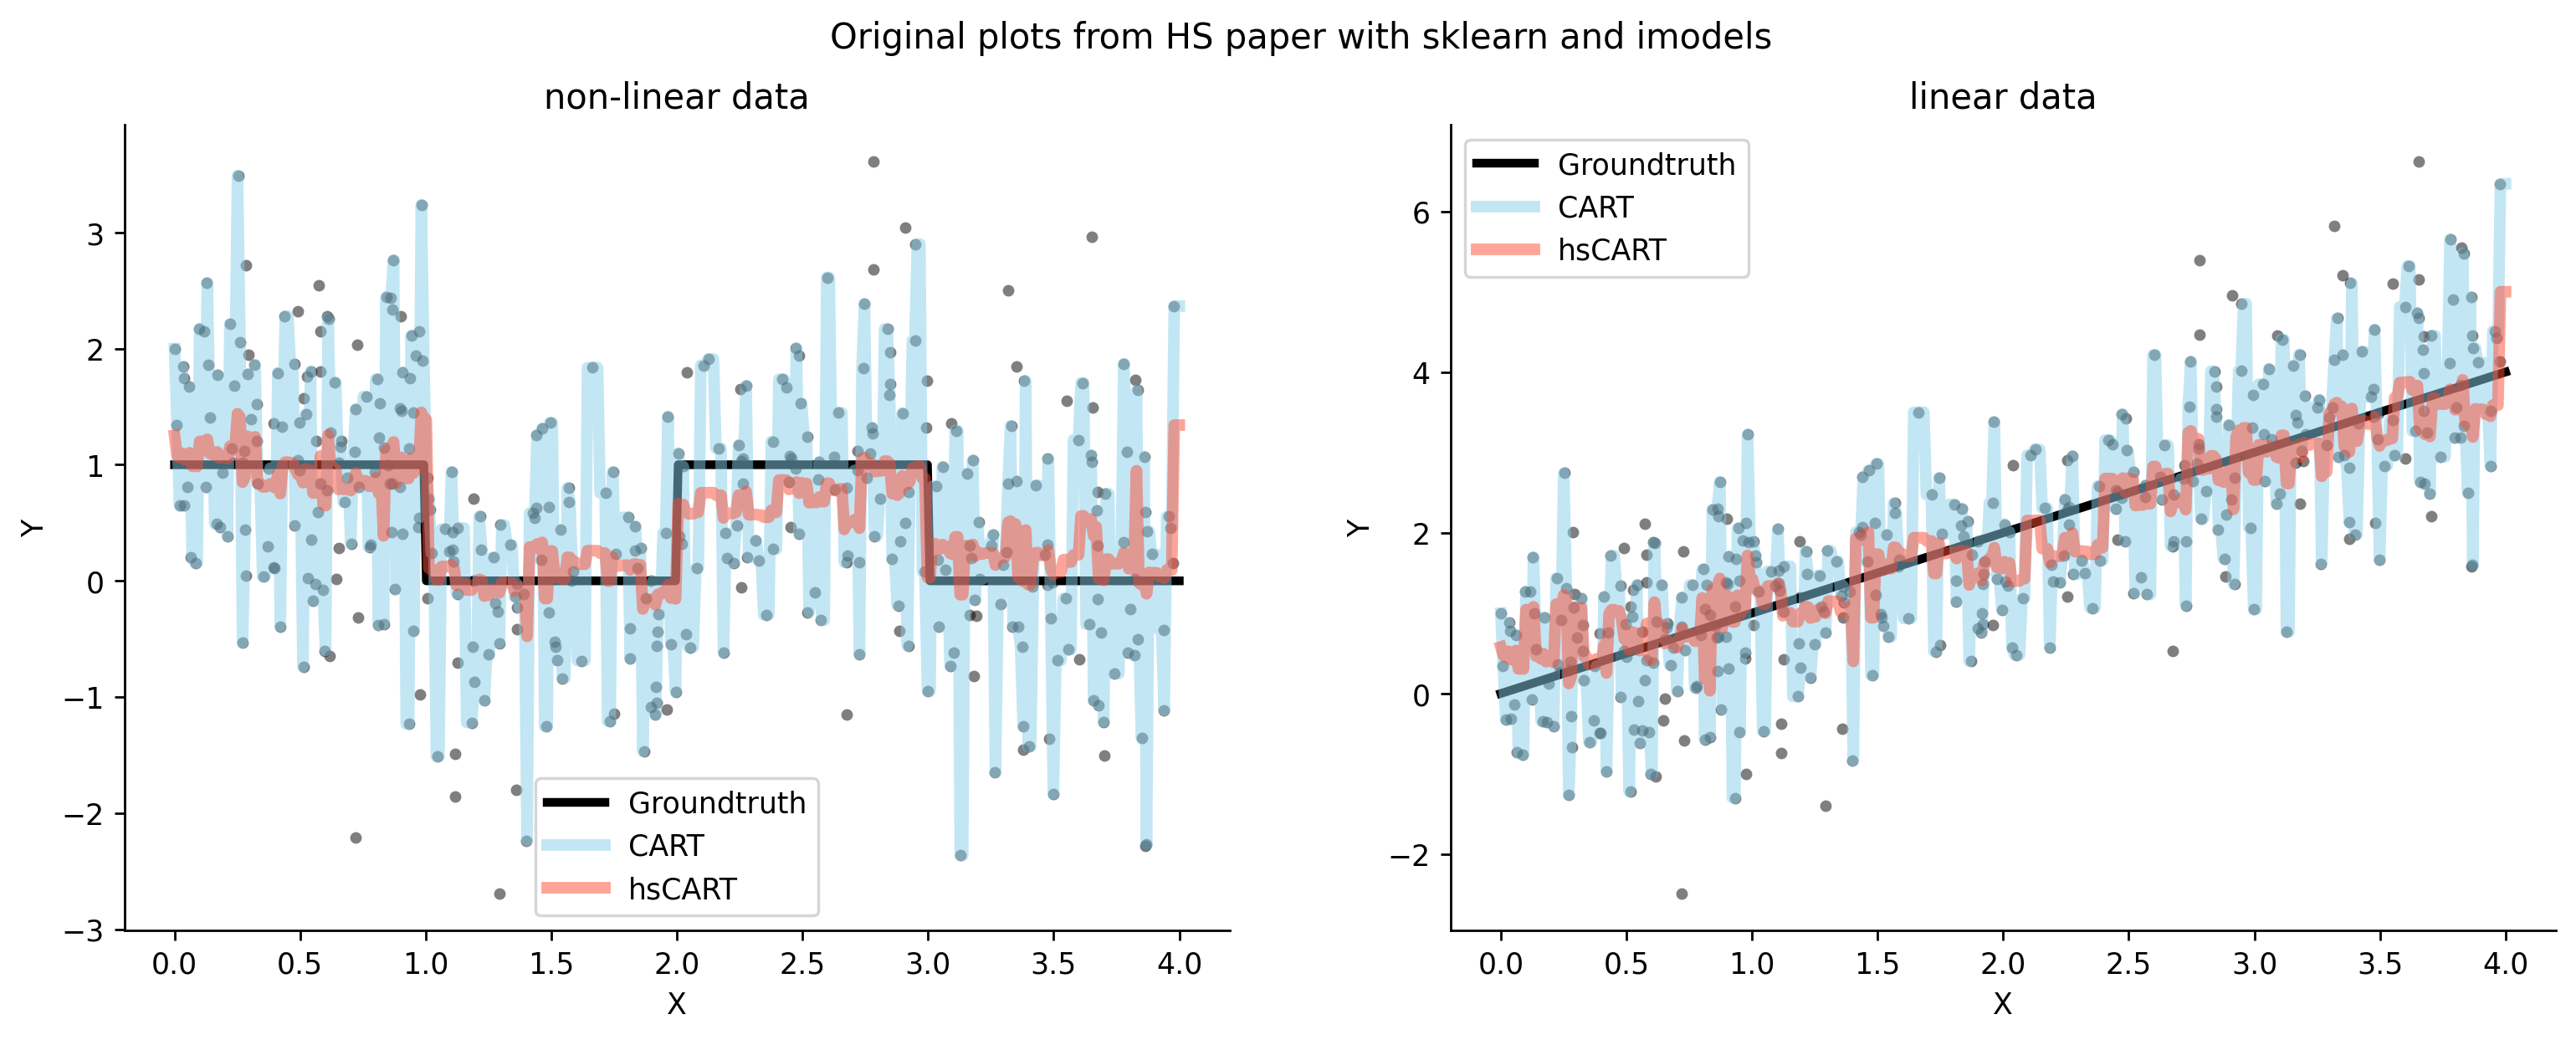

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Original plots from HS paper with sklearn and imodels")
_, y_orig_lin, _, _, y_pred_dt_orig_lin, y_pred_shrunk_orig_lin = plot_sim(
    n=400, std=1, reg_param=100, show='pass', ax=axs[0], return_curves=True)
_, y_orig_nonlin, _, _, y_pred_dt_orig_nonlin, y_pred_shrunk_orig_nonlin = plot_sim(
    n=400, std=1, reg_param=50, linear_data=True, show='pass', ax=axs[1], return_curves=True)

axs[1].set_title('linear data')
axs[0].set_title('non-linear data');

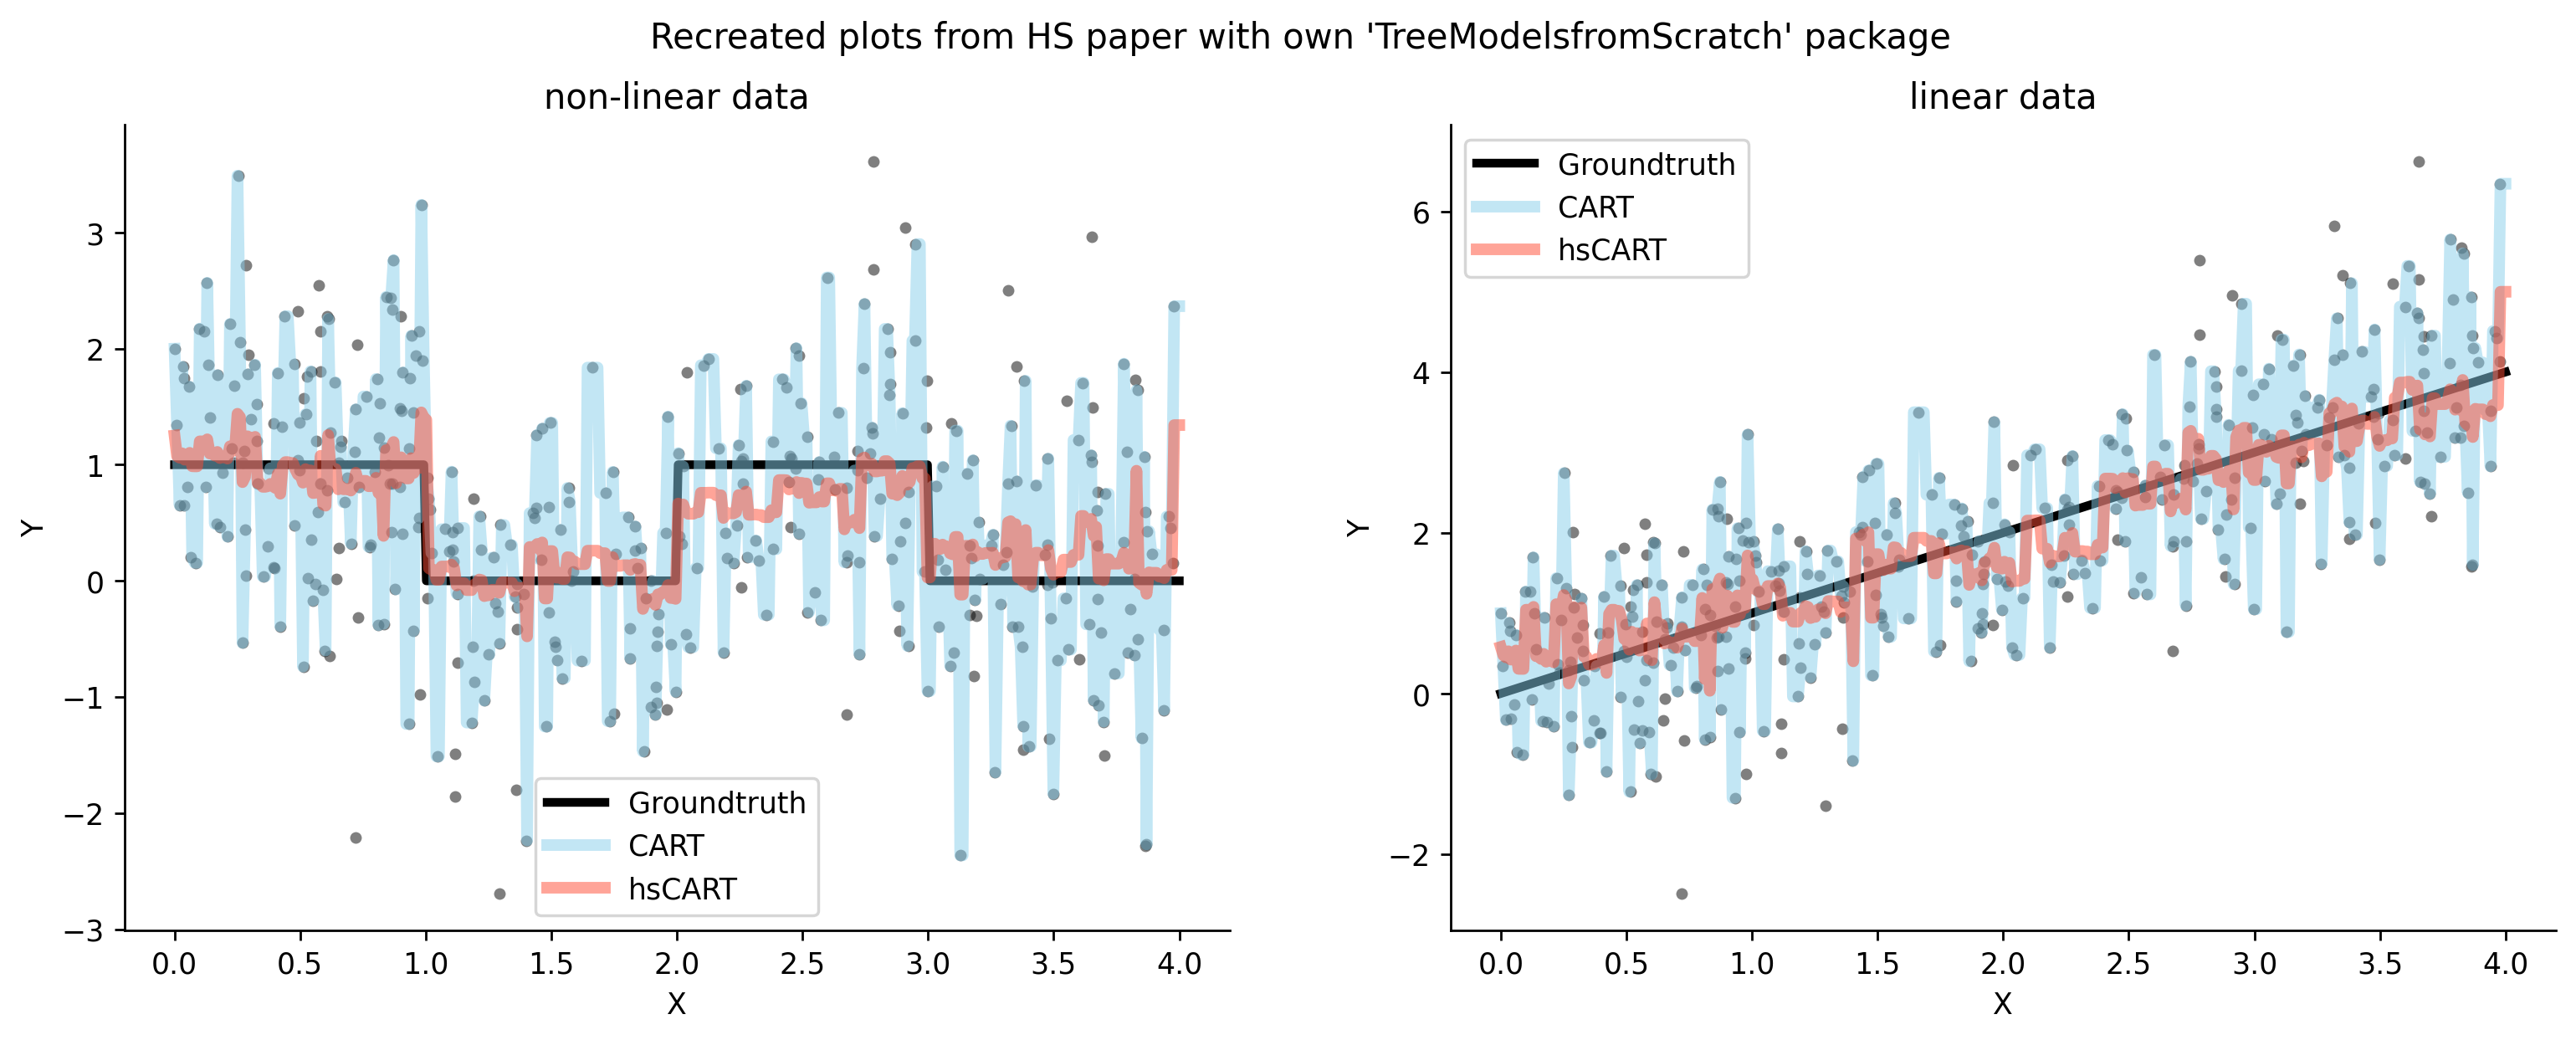

In [8]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Recreated plots from HS paper with own 'TreeModelsfromScratch' package")

_, y_scra_lin, _, _, y_pred_dt_scra_lin, y_pred_shrunk_scra_lin = plot_sim(
    n=400, std=1, reg_param=100, use_imodels=False, show='pass', ax=axs[0], return_curves=True)
_, y_scra_nonlin, _, _, y_pred_dt_scra_nonlin, y_pred_shrunk_scra_nonlin = plot_sim(
    n=400, std=1, reg_param=50, use_imodels=False, linear_data=True, show='pass', ax=axs[1], return_curves=True)

axs[1].set_title('linear data')
axs[0].set_title('non-linear data');

The plots seem to be identical (or at least very close). But to make sure the predictions/ model performance is indeed close, we will compare the prediction values and compute MSE scores for the original paper and the scratch models.

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
np.array_equal(y_scra_lin, y_orig_lin)

True

In [11]:
np.array_equal(y_pred_dt_scra_lin, y_pred_dt_orig_lin)

True

In [12]:
np.array_equal(y_pred_dt_scra_nonlin, y_pred_dt_orig_nonlin)

True

In [13]:
print("MSE CART sklearn:", mean_squared_error(y_scra_lin, y_pred_dt_orig_lin))
print("MSE CART scratch:", mean_squared_error(y_scra_lin, y_pred_dt_scra_lin))

MSE CART sklearn: 1.8691503121023338
MSE CART scratch: 1.8691503121023338


In [14]:
np.array_equal(y_pred_shrunk_scra_lin.round(8), y_pred_shrunk_orig_lin.round(8))

True

In [15]:
np.array_equal(y_pred_shrunk_scra_nonlin.round(8), y_pred_shrunk_orig_nonlin.round(8))

True

In [16]:
print("MSE hsCART sklearn:", mean_squared_error(y_scra_lin, y_pred_shrunk_orig_lin))
print("MSE hsCART scratch:", mean_squared_error(y_scra_lin, y_pred_shrunk_scra_lin))

MSE hsCART sklearn: 1.0940734057905461
MSE hsCART scratch: 1.0940734057905461


The predictions/ MSE scores for both cases are identical for both packages

## Decision boundaries (Fig. 5 and Appendix S5.1)

I did not find the code for the plots shown in the paper. Instead I will follow the description on how the plots were created: 
>  *For each of our classification datasets, we fit an RF with 50 trees using only the two most important features, as measured using Mean Decrease in Impurity (MDI) feature importance. We also apply HS post hoc to the fitted RF model to obtain a second model.*

### Diabetes dataset (Fig. 5)

In [80]:
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[5]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

#### Get most important features

In [81]:
rf_diabetes_sk = RandomForestClassifier(n_estimators=50, random_state=1)
rf_diabetes_sk.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

In [82]:
#MDI feature importance
rf_diabetes_sk.feature_importances_

array([0.08573712, 0.27216103, 0.08407917, 0.07093551, 0.06969634,
       0.16072398, 0.12155217, 0.13511468])

In [83]:
# Get 1st and 2nd most important feature according to MDI
most_imp_feats = np.argsort(rf_diabetes_sk.feature_importances_, axis=0)[-2:][::-1]

In [86]:
# get feature names
most_imp_feats_names = [feat_names[i] for i in most_imp_feats]
most_imp_feats_names

['A2', 'A6']

In [90]:
X_small = X_train[:,most_imp_feats].copy()

#### Refit estimator and recreate plot from original paper with sklearn and imodels

In [91]:
#refit estimator using only these two features
rf_diabetes_clf_sk = RandomForestClassifier(n_estimators=50, random_state=1)
rf_diabetes_clf_sk.fit(X_small, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

In [140]:
#fit imodels
rf_diabetes_clf_im = imodels.HSTreeClassifier(deepcopy(rf_diabetes_clf_sk), reg_param=100)
y_pred_shrunk = rf_diabetes_clf_im.predict(X_test[:,most_imp_feats])

In [141]:
auc_rf_sk = roc_auc_score(y_test, rf_diabetes_clf_sk.predict(X_test[:,most_imp_feats]))
auc_rf_imodels = roc_auc_score(y_test, y_pred_shrunk)

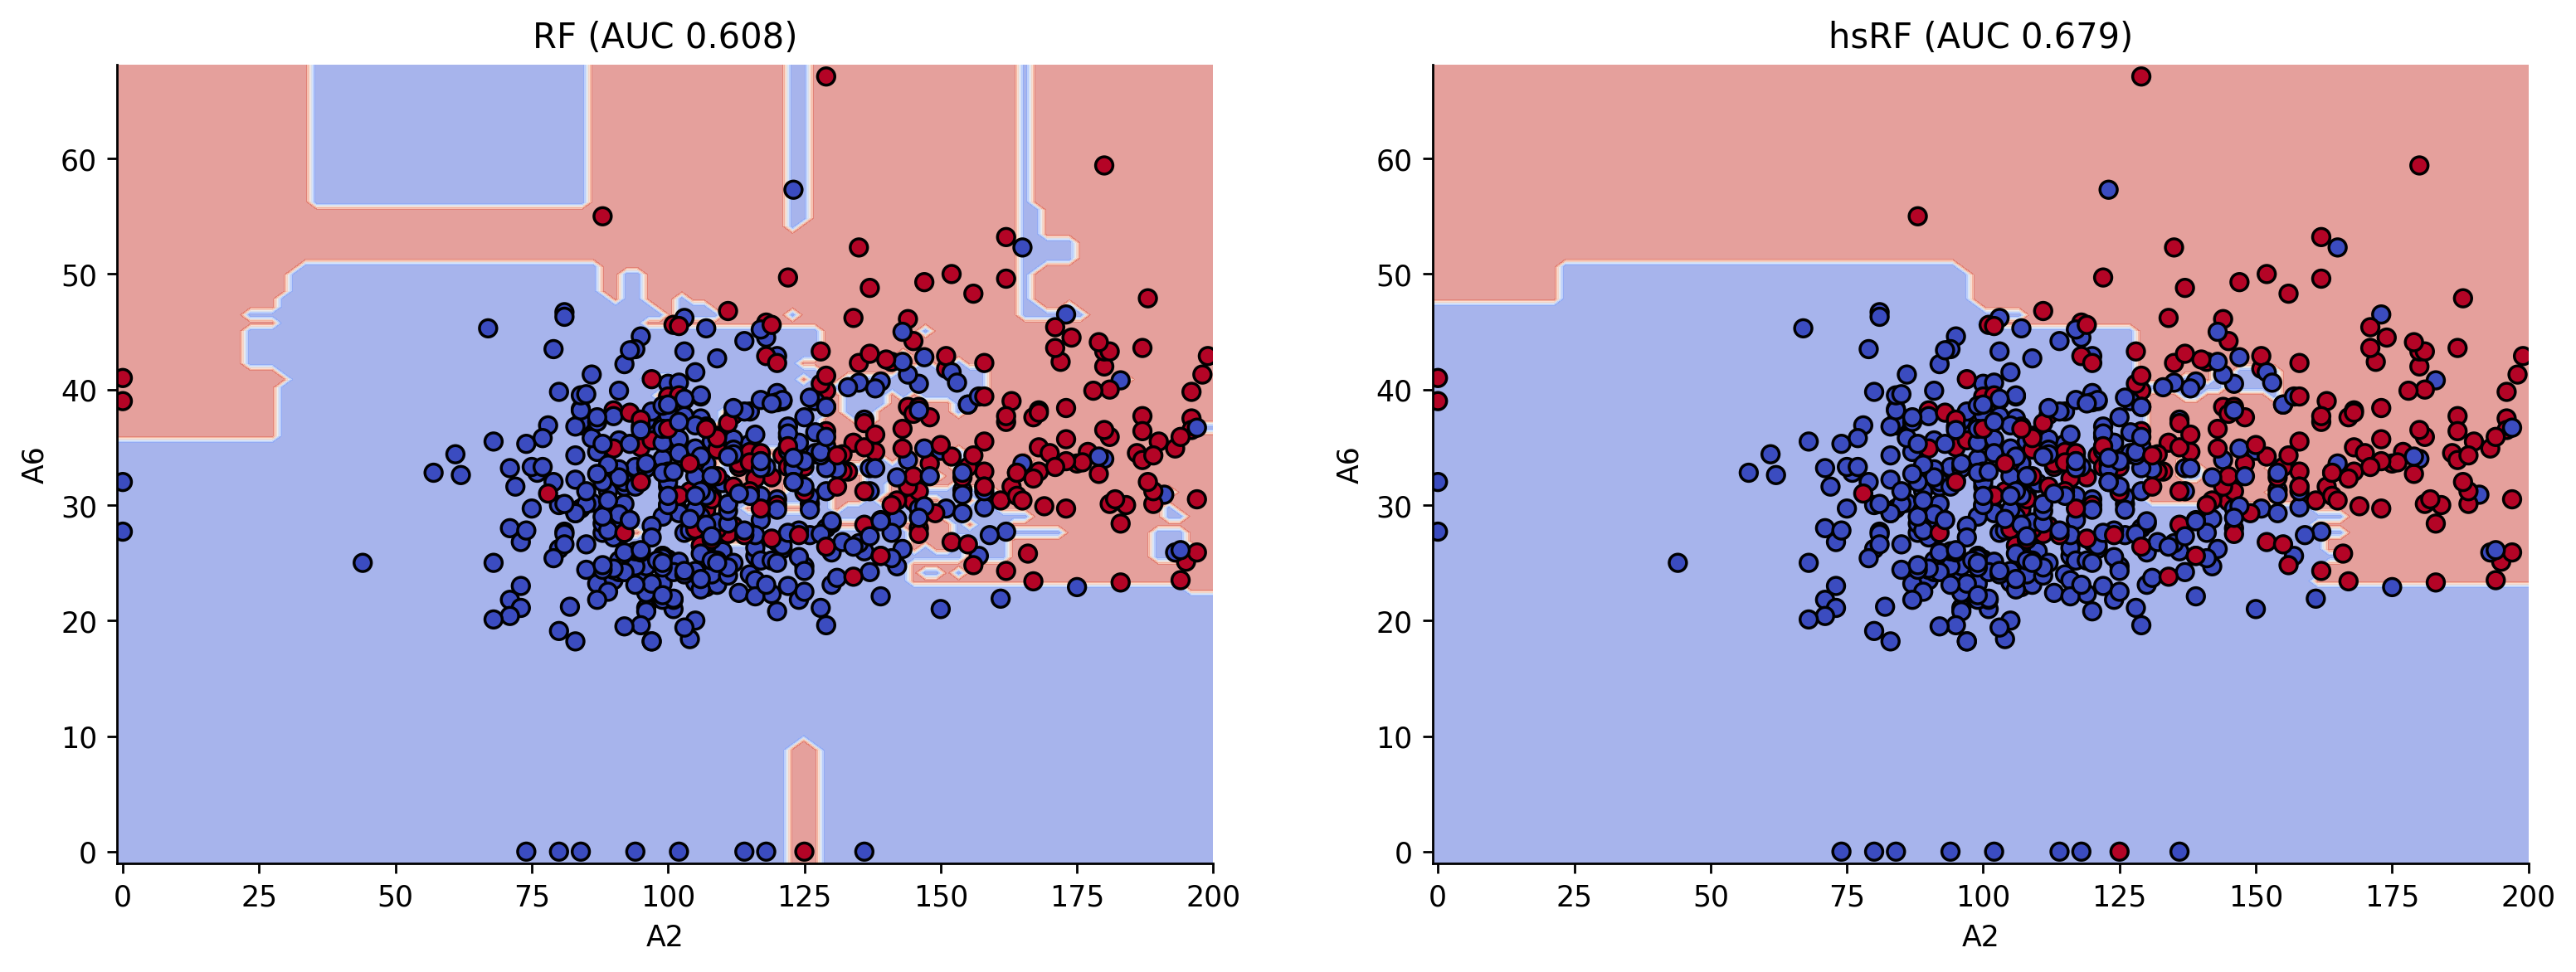

In [194]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# sklearn
disp = DecisionBoundaryDisplay.from_estimator(
    rf_diabetes_clf_sk, X_small, response_method="predict", cmap=plt.cm.coolwarm,
    xlabel=most_imp_feats_names[0], ylabel=most_imp_feats_names[1],
    alpha=0.5, ax=axs[0]
)
axs[0].scatter(X_small[:, 0], X_small[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.coolwarm)
axs[0].set_title(f"RF (AUC {np.round(auc_rf_sk,3)})");

# imodels
disp_im = DecisionBoundaryDisplay.from_estimator(
    rf_diabetes_clf_im, X_small, response_method="predict", cmap=plt.cm.coolwarm, 
    xlabel=most_imp_feats_names[0], ylabel=most_imp_feats_names[1],
    alpha=0.5, ax=axs[1]
)
axs[1].scatter(X_small[:, 0], X_small[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.coolwarm)

axs[1].set_title(f"hsRF (AUC {np.round(auc_rf_imodels,3)})");

Does not look 100% like the figure from the paper, but close enough.

#### Recreate plot with `TreeModelsfromScratch` package

In [180]:
#RF scratch
rf_diabetes_clf_scr = RandomForest(n_trees=50, treetype='classification', n_feature=1, random_state=1)
rf_diabetes_clf_scr.fit(X_small, y_train)

"is not" with a literal. Did you mean "!="?


In [182]:
y_pred_scratch = rf_diabetes_clf_scr.predict(X_test[:,most_imp_feats])

In [181]:
#HS scratch
rf_diabetes_clf_scr_HS = RandomForest(n_trees=50, treetype='classification', n_feature=1, 
                                      HShrinkage=True, HS_lambda=100, random_state=1)
rf_diabetes_clf_scr_HS.fit(X_small, y_train)

In [183]:
y_pred_scratch_HS = rf_diabetes_clf_scr_HS.predict(X_test[:,most_imp_feats])

In [184]:
# AUC scores for plot
auc_rf_scratch = roc_auc_score(y_test, y_pred_scratch)
auc_rf_scratch_HS = roc_auc_score(y_test, y_pred_scratch_HS)

In [188]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

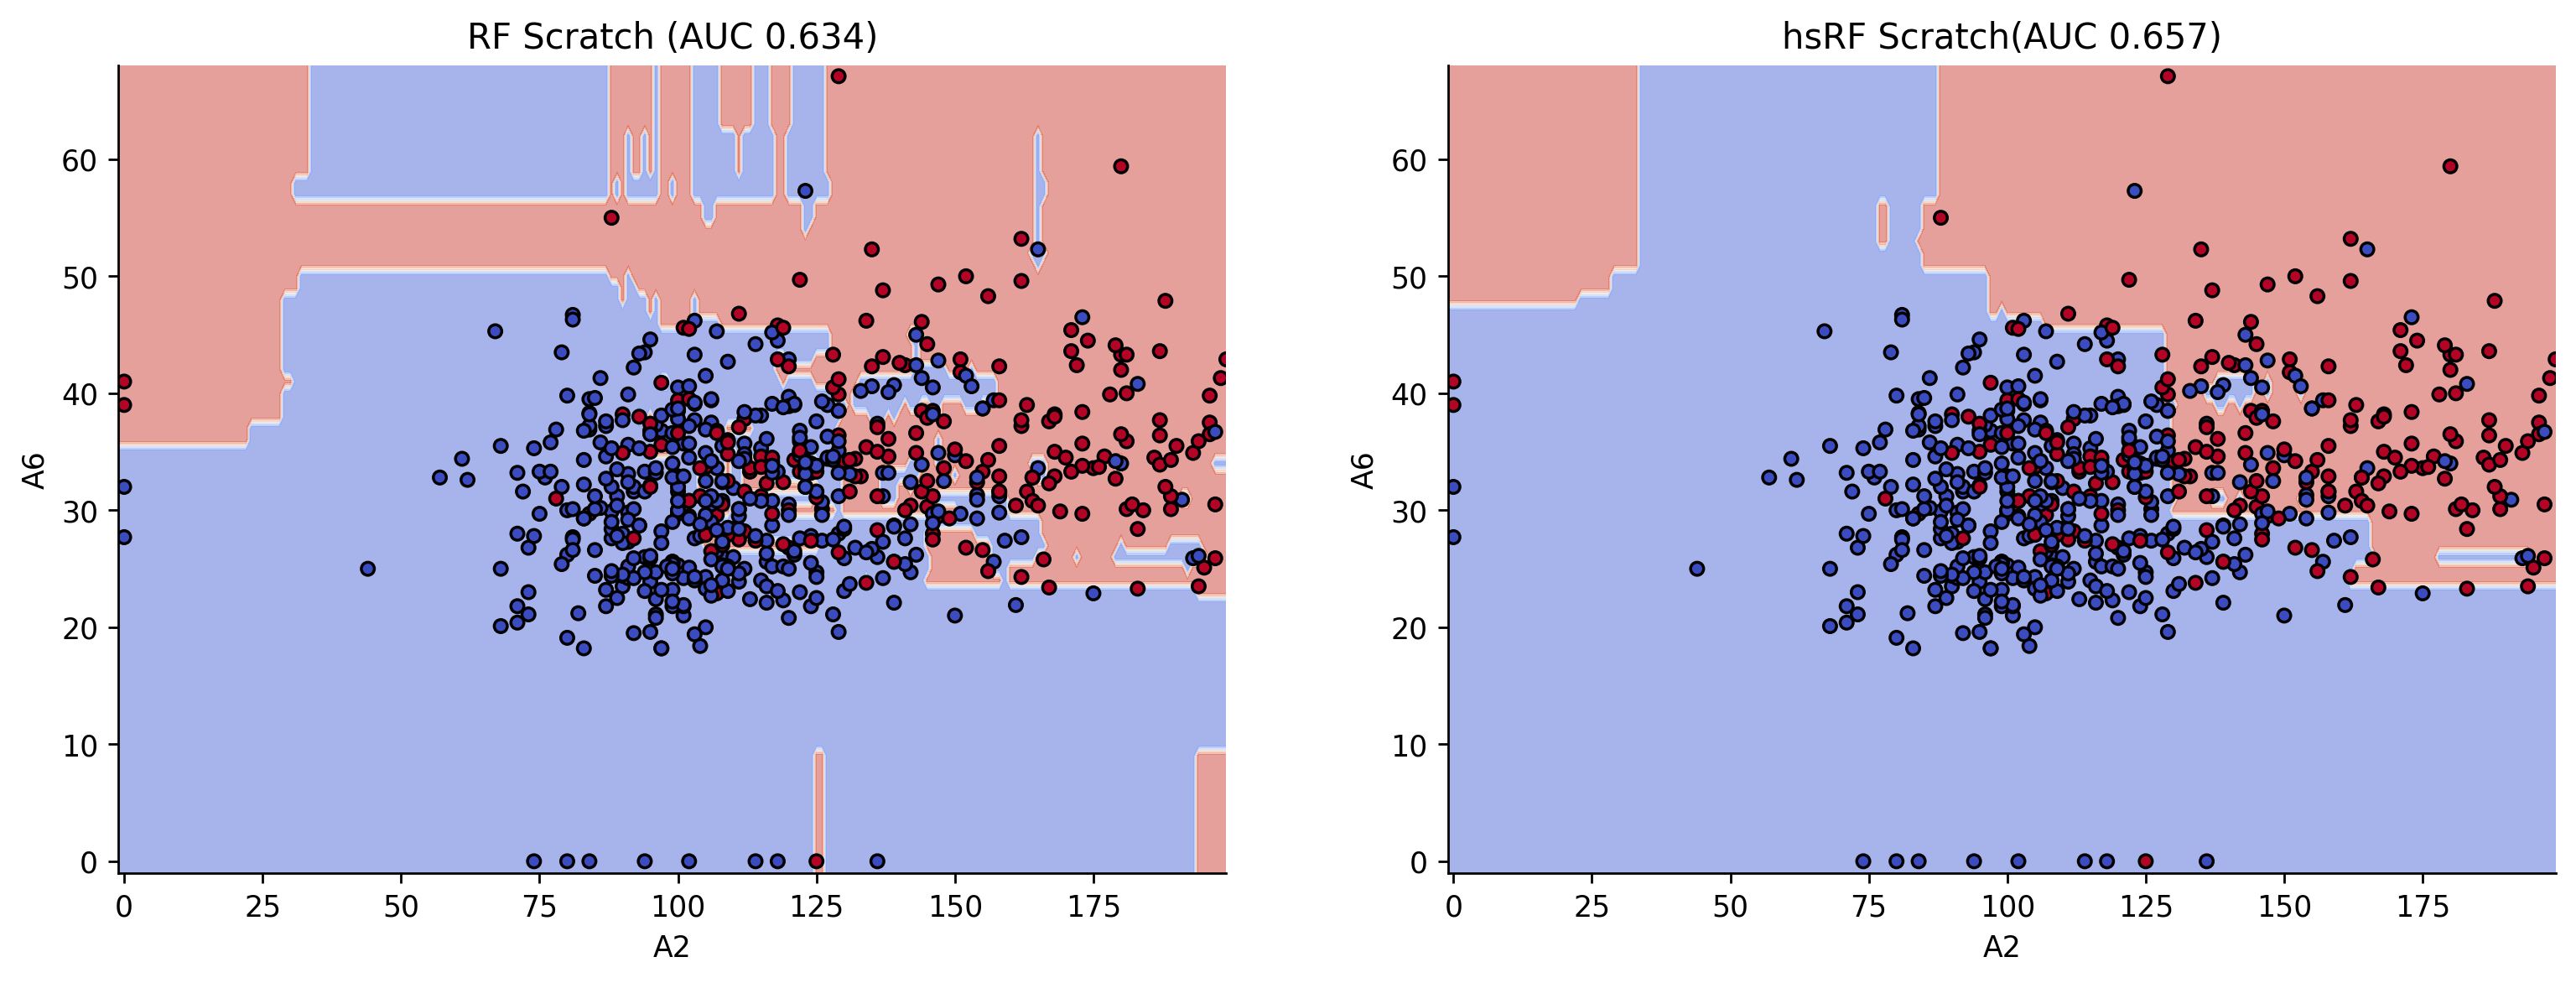

In [197]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# Set-up grid for plotting.
X0, X1 = X_small[:, 0], X_small[:, 1]
xx, yy = make_meshgrid(X0, X1, h=1)

# Scratch
plot_contours(axs[0], rf_diabetes_clf_scr, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
axs[0].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axs[0].set_ylabel(most_imp_feats_names[1])
axs[0].set_xlabel(most_imp_feats_names[0])
axs[0].set_title(f"RF Scratch (AUC {np.round(auc_rf_scratch,3)})")

# Scratch with HS
plot_contours(axs[1], rf_diabetes_clf_scr_HS, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
axs[1].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axs[1].set_ylabel(most_imp_feats_names[1])
axs[1].set_xlabel(most_imp_feats_names[0])
axs[1].set_title(f"hsRF Scratch(AUC {np.round(auc_rf_scratch_HS,3)})");